In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Link to the EDA and naive time-series model
## [Energy consumption in NL](https://www.kaggle.com/raaavan/bi-directional-lstm-ts)

(still under construction, I work in this whenever I can)

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Bidirectional, Dense,Dropout,LSTM,Activation, RepeatVector, SimpleRNN

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from datetime import datetime

import matplotlib.pyplot as plt

import os, glob

In [3]:
years = ['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020']
companies = ['stedin', 'liander','enduris', 'enexis','westland-infra','rendo','coteq'] 

In [4]:
path = r'../input/dutch-energy/Electricity/' 

stedin=[]
liander = []
enduris = []
enexis = []
westland_infra = []
rendo = []
coteq = []

for company in companies:
    all_files = glob.glob(f"{path}/{company}*.csv")
    for file in all_files:
        print(company, file)
        for year in years:
            if year in file:
                print(f"adding column year {year} to {file}")
        
                comp_df = company
                print(f"processing for : {comp_df}")
                comp_df = pd.read_csv(file, index_col=None, header=0)
                comp_df['year'] = year

                if company == companies[0]:
                    stedin.append(comp_df)

                elif company == companies[1]:
                    liander.append(comp_df)
                    
                elif company == companies[2]:
                        enduris.append(comp_df)
                        
                elif company == companies[3]:
                    enexis.append(comp_df)

                elif company == companies[4]:
                    westland_infra.append(comp_df)

                elif company == companies[5]:
                    rendo.append(comp_df)

                elif company == companies[6]:
                    coteq.append(comp_df)  


                
        print('-------------------------------')


stedin ../input/dutch-energy/Electricity/stedin_electricity_2017.csv
adding column year 2017 to ../input/dutch-energy/Electricity/stedin_electricity_2017.csv
processing for : stedin
-------------------------------
stedin ../input/dutch-energy/Electricity/stedin_electricity_2019.csv
adding column year 2019 to ../input/dutch-energy/Electricity/stedin_electricity_2019.csv
processing for : stedin
-------------------------------
stedin ../input/dutch-energy/Electricity/stedin_electricity_2011.csv
adding column year 2011 to ../input/dutch-energy/Electricity/stedin_electricity_2011.csv
processing for : stedin
-------------------------------
stedin ../input/dutch-energy/Electricity/stedin_electricity_2010.csv
adding column year 2010 to ../input/dutch-energy/Electricity/stedin_electricity_2010.csv
processing for : stedin
-------------------------------
stedin ../input/dutch-energy/Electricity/stedin_electricity_2015.csv
adding column year 2015 to ../input/dutch-energy/Electricity/stedin_electri

In [5]:
stedin_df = pd.concat(stedin, axis=0, ignore_index=True)
# liander_df = pd.concat(liander, axis=0, ignore_index=True)
# enduris_df = pd.concat(enduris, axis=0, ignore_index=True)
# enexis_df = pd.concat(enexis, axis=0, ignore_index=True)
# westland_infra_df = pd.concat(westland_infra, axis=0, ignore_index=True)
# rendo_df = pd.concat(rendo, axis=0, ignore_index=True)
# coteq_df = pd.concat(coteq, axis=0, ignore_index=True)

In [6]:
stedin_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999434 entries, 0 to 999433
Data columns (total 16 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   net_manager                   999434 non-null  int64  
 1   purchase_area                 999434 non-null  object 
 2   street                        999434 non-null  object 
 3   zipcode_from                  999434 non-null  object 
 4   zipcode_to                    999434 non-null  object 
 5   city                          999434 non-null  object 
 6   num_connections               999434 non-null  int64  
 7   delivery_perc                 999434 non-null  float64
 8   perc_of_active_connections    999434 non-null  float64
 9   type_conn_perc                999434 non-null  float64
 10  type_of_connection            999434 non-null  object 
 11  annual_consume                999434 non-null  float64
 12  annual_consume_lowtarif_perc  999434 non-nul

In [7]:
stedin_df.isna().sum()


net_manager                          0
purchase_area                        0
street                               0
zipcode_from                         0
zipcode_to                           0
city                                 0
num_connections                      0
delivery_perc                        0
perc_of_active_connections           0
type_conn_perc                       0
type_of_connection                   0
annual_consume                       0
annual_consume_lowtarif_perc         0
smartmeter_perc                      0
year                                 0
STANDAARDDEVIATIE               913096
dtype: int64

In [8]:
stedin_df = stedin_df.drop('STANDAARDDEVIATIE', 1)


In [9]:
stedin_df.head()

,net_manager,purchase_area,street,zipcode_from,zipcode_to,city,num_connections,delivery_perc,perc_of_active_connections,type_conn_perc,type_of_connection,annual_consume,annual_consume_lowtarif_perc,smartmeter_perc,year
0,8716874000009,Stedin Utrecht,Gijsbrecht van Amstelln,1181EJ,1231AB,AMSTELVEEN,33,96.97,90.91,79.0,3x25,5203.0,81.82,9.09,2017
1,8716874000009,Stedin Utrecht,Rembrandtlaan,1231AC,1231AC,LOOSDRECHT,17,100.00,100.00,41.0,1x25,3181.0,76.47,17.65,2017
2,8716874000009,Stedin Utrecht,Rembrandtlaan,1231AD,1231AD,LOOSDRECHT,17,100.00,100.00,47.0,3x25,3717.0,76.47,5.88,2017
3,8716874000009,Stedin Utrecht,Jan Steenlaan,1231AE,1231AE,LOOSDRECHT,20,100.00,100.00,45.0,3x25,4644.0,85.00,15.00,2017
4,8716874000009,Stedin Utrecht,Pieter de Hooghlaan,1231AG,1231AG,LOOSDRECHT,17,100.00,100.00,71.0,1x25,3526.0,64.71,0.00,2017


In [10]:
def normalization_mx(data):
    
    """takes data and scales it 
    between 0 to 1
    """
    
    dataset = data.values.reshape(-1,1)

    sclar = MinMaxScaler(feature_range=(0,1))
    dataset = sclar.fit_transform(dataset)
    return dataset




def normilization(data):
    
    """takes data and scales it 
    between 0 to 1
    """
    
    dataset = data.iloc[:,11].astype('float32')
    
    max_value = np.max(dataset)
    min_value = np.min(dataset)
    
    scalar = max_value - min_value
    dataset = list(map(lambda x: (x-min_value) / scalar, dataset))
    return np.array(dataset)

In [11]:
norm_data = normilization(stedin_df)

In [12]:
def load_data(dataset, seq_len):
    X_train = []
    y_train = []
    split_size = int(0.8 * len(dataset))
    
    for i in range(seq_len, len(dataset)):
        X_train.append(dataset[i - seq_len: i, 0])
        y_train.append(dataset[i, 0])

   
    X_test = X_train[split_size:]
    y_test = y_train[split_size:]

   
    X_train = X_train[:split_size]
    y_train = y_train[:split_size]

    X_train = np.array(X_train)
    y_train = np.array(y_train)

    X_test = np.array(X_test)
    y_test = np.array(y_test)

    return [X_train, y_train, X_test, y_test]

In [13]:
seq_len = 120 #choose sequence length
label_len = 10 #choose labellen

X_train, y_train, X_test, y_test = load_data(tf.expand_dims(norm_data, axis = 1), seq_len)

In [14]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((799547, 120), (199767, 120), (799547,), (199767,))

In [15]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, MaxPooling1D, TimeDistributed, LSTM, BatchNormalization, Input, concatenate, Conv1D

def cnn_lstm(train_x, train_y, test_x):
    
    model=Sequential()
    model.add(TimeDistributed(Conv1D(16, 2, padding = "same", strides = 1, activation = "relu"),input_shape=(None, train_x.shape[1], 1)))
    model.add(TimeDistributed(MaxPooling1D(2)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(50, return_sequences = True))
    model.add(LSTM(10))
    model.add(Dense(1, activation = "relu"))
    model.compile(optimizer = "adam",loss = "mse")
    
    model.summary()
    # reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
    history = model.fit(train_x.reshape(len(train_x), 1, train_x.shape[1], 1) ,train_y, batch_size=32, epochs=50, verbose=1, validation_split=0.3)
    #prediction
    pred = model.predict(test_x.reshape(len(test_x),1, test_x.shape[1], 1))
    return model, pred, history

In [16]:
cnnlstm_model, cnnlstm_pred, cnn_history = cnn_lstm(X_train, y_train, X_test)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, None, 120, 16)     48        
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 60, 16)      0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 960)         0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 50)          202200    
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                2440      
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 204,699
Trainable params: 204,699
Non-trainable params: 0
__________________________________________________

In [17]:
y_test

array([0.03979   , 0.04872944, 0.04261346, ..., 0.02591564, 0.03832712,
       0.03262356])

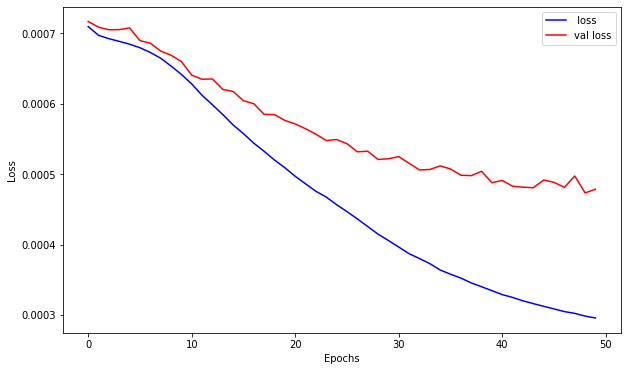

<Figure size 432x288 with 0 Axes>

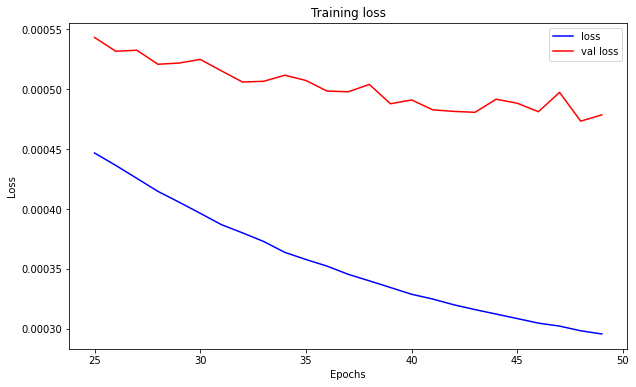

<Figure size 432x288 with 0 Axes>

In [18]:
import matplotlib.pyplot as plt
def plot_curve(history):
    plt.figure(figsize=(10, 6))

    # — — — — — — — — — — — — — — — — — — — — — — — — — — — — — -
    # Retrieve a list of list results on training and test data
    # sets for each training epoch
    # — — — — — — — — — — — — — — — — — — — — — — — — — — — — — -
    loss=history.history['loss']
    val_loss = history.history['val_loss']
    epochs=range(len(loss)) # Get number of epochs
    # — — — — — — — — — — — — — — — — — — — — — — — — 
    # Plot training and validation loss per epoch
    # — — — — — — — — — — — — — — — — — — — — — — — — 
    plt.plot(epochs, loss, 'b', label = ' loss')
    plt.plot(epochs, val_loss, 'r', label = 'val loss')
     
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.figure()
    zoomed_loss = loss[25:]
    zoomed_val_loss = val_loss[25:]
    zoomed_epochs = range(25,50)
    # — — — — — — — — — — — — — — — — — — — — — — — — 
    # Plot training and validation loss per epoch
    # — — — — — — — — — — — — — — — — — — — — — — — — 
    plt.figure(figsize=(10, 6))

    plt.plot(zoomed_epochs, zoomed_loss, 'b', label = 'loss')
    plt.plot(zoomed_epochs, zoomed_val_loss, 'r', label = 'val loss')
    plt.title('Training loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.figure()
    
plot_curve(cnn_history)

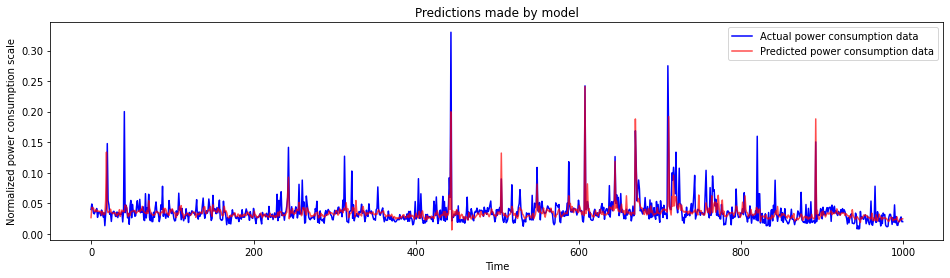

In [28]:
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16, 4))
   
    plt.plot(test, color='blue', label='Actual power consumption data')
    plt.plot(predicted, alpha=0.7, color='red', label='Predicted power consumption data')
    
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption scale')
    
    plt.legend()
    plt.show()


plot_predictions(y_test[:1000], tf.squeeze(cnnlstm_pred[:1000]), "Predictions made by model")

In [20]:
y_test[:10] - tf.squeeze(cnnlstm_pred[:10])

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([ 1.3332594e-02,  5.7041533e-03,  1.5284829e-03, -7.9078451e-03,
       -4.1995868e-03, -5.6173652e-05, -3.0758344e-03,  5.0542317e-03,
       -1.0828927e-02, -2.7107075e-03], dtype=float32)>

In [21]:
tf.squeeze(cnnlstm_pred[:10])

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.02645741, 0.04302529, 0.04108498, 0.04222232, 0.03674602,
       0.03658973, 0.03960036, 0.0363234 , 0.03767432, 0.03685379],
      dtype=float32)>

In [22]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
def mean_absolute_percentage_error(y_true, y_pred):
    """MAPE"""
    error=np.array(np.abs((y_true - y_pred) / y_true))
    mse=np.mean(error,axis=0) * 100
    return mse

In [23]:
# mean_absolute_percentage_error(y_test, cnnlstm_pred)

In [24]:
def eval_score(y_test, y_true):
    mae = mean_absolute_error(y_test, y_true)
    mse = mean_squared_error(y_test, y_true)
     
    
    return f"mae : {mae}, mse : {mse}"

In [25]:
eval_score(y_test, cnnlstm_pred)

'mae : 0.012355027273068586, mse : 0.0005889522553560446'

In [26]:
def evluation(real,pred,data,data_name):
    """Real: the true value
       Pred: predicted value
       Data: the name of data"""
    dataset = data.iloc[:,11].astype('float32')
    max_value = np.max(dataset)
    min_value = np.min(dataset)
    scalar = max_value - min_value
    pred=pd.DataFrame(list(map(lambda x: x*scalar+min_value ,pred)))
    real=pd.DataFrame(list(map(lambda x: x*scalar+min_value ,real)))
    mse=mean_squared_error(real,pred)
    print("MSE of %s is %f"%(data_name,mse))
    mae=mean_absolute_error(real,pred)
    print("MAE of %s is %f"%(data_name,mae))
    rmse=np.sqrt(mean_squared_error(real,pred))
    print("RMSE of %s is %f"%(data_name,rmse))
#     mape=mean_absolute_percentage_error(real,pred)
#     print("MAPE of %s is %f"%(data_name,mape))

In [27]:
evluation(y_test, tf.squeeze(cnnlstm_pred), stedin_df, 'stedin-data')

MSE of stedin-data is 7237795.907662
MAE of stedin-data is 1369.641259
RMSE of stedin-data is 2690.315206
